## Tips & tricks 2 : Force an unique solution

The next tutorials provides tips and tricks to help the solver in case of models with identical components. The following behaviors are expectable in case of redundant models:

-   The solution can change from a run to the next;
-   Two production means with the same price can randomly turn on and off;
-   Two batteries can charge-discharge in each other.

These behaviors are dependant on the MILP solver presolve initial state. For model regression purposes or better results readability, it is possible to slightly tweak the model fix these behaviors without loosing the model physics.

Understanding this serie requires having followed the EESREP user tutorials.

In this model, we will have a load, an initially charged battery and an expensive source.

As the battery is not charged enough to provide all the load, the expensive source will be called. At constant price, the source can be called at any time of the simulation.

####  Base model

In [1]:
import math

import matplotlib.pyplot as plt
import pandas as pd

from eesrep import Eesrep
from eesrep.components.bus import GenericBus
from eesrep.components.sink_source import FatalSink, Source
from eesrep.components.storage import GenericStorage

In [2]:
model = Eesrep(interface="docplex")

expensive_unit = Source(name="expensive_unit", p_min = 0., p_max = 100, price=100.)

fs_df = pd.DataFrame({"time": list(range(50)), 
                            "value": [10 for _ in range(50)]})

load = FatalSink(name="load", 
                        sink_flow = fs_df)

storage = GenericStorage(name="storage", p_max=100, storage_max=400, efficiency=1., init_storage=1.)

model.add_component(expensive_unit)
model.add_component(storage)
model.add_component(load)

bus = GenericBus("bus")
model.add_component(bus)
                        
model.plug_to_bus(io = expensive_unit.power_out, bus_io = bus.input, factor=1., offset=0.)
model.plug_to_bus(io = storage.flow, bus_io = bus.output, factor=1., offset=0.)
model.plug_to_bus(io = load.power_in, bus_io = bus.output, factor=1., offset=0.)

model.define_time_range(time_step = 1., 
                        time_shift = 1, 
                        future_size = 50, 
                        horizon_count = 1)
                        
model.solve()

Running first time step


As we can see in the results below, the expensive source can be called anytime, even to charge the battery that will provide the source later on.

Total price : 9000.0.


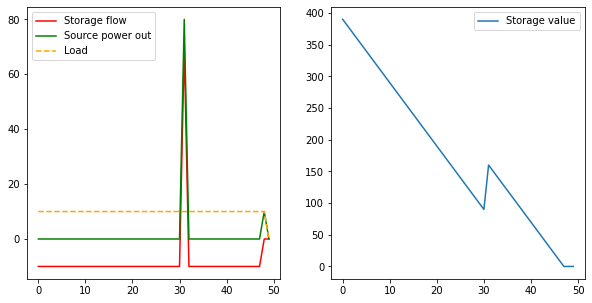

In [3]:
results = model.get_results(as_dataframe=False)

print(f"Total price : {sum(results['expensive_unit']['power_out'])*100}.")

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(results["storage"]["flow"], label = "Storage flow", color="r")
plt.plot(results["expensive_unit"]["power_out"], label = "Source power out", color="g")
plt.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="orange")
plt.legend()
plt.subplot(122)
plt.plot(results["storage"]["storage"], label = "Storage value")
plt.legend()
plt.show()

####  Tweaked model

The behavior shown above can be fixed by changing the price along time, for example:

-   Price decreasing with time: we favorise using the expensive unit at the last time steps;
-   Price increasing with time: we favorise using the expensive unit at the first time steps.

Instead of changing the price, we could reduce slightly the efficiency of the battery, the implied losses would suggest the solver not to charge it and provide the load directly instead; but that would not solve the free choice of when to use the expensive unit.

The time-decreasing price is illustrated below.

In [4]:
model = Eesrep(interface="docplex")

price_ts = pd.DataFrame({"time": list(range(50)), 
                            "value": [10-0.0000001*i for i in range(50)]})

expensive_unit = Source(name="expensive_unit", p_min = 0., p_max = 100, price=100., price_variation=price_ts)

fs_df = pd.DataFrame({"time": list(range(50)), 
                            "value": [10 for _ in range(50)]})

load = FatalSink(name="load", 
                        sink_flow = fs_df)

storage = GenericStorage(name="storage", p_max=100, storage_max=400, efficiency=1., init_storage=1.)

model.add_component(expensive_unit)
model.add_component(storage)
model.add_component(load)

bus = GenericBus("bus")
model.add_component(bus)
                        
model.plug_to_bus(io = expensive_unit.power_out, bus_io = bus.input, factor=1., offset=0.)
model.plug_to_bus(io = storage.flow, bus_io = bus.output, factor=1., offset=0.)
model.plug_to_bus(io = load.power_in, bus_io = bus.output, factor=1., offset=0.)

model.define_time_range(time_step = 1., 
                        time_shift = 1, 
                        future_size = 50, 
                        horizon_count = 1)
                        
model.solve()

Running first time step


We can see below that the expected behavior is now respected, with a negligible change of total price.

Total price : 89999.9604.


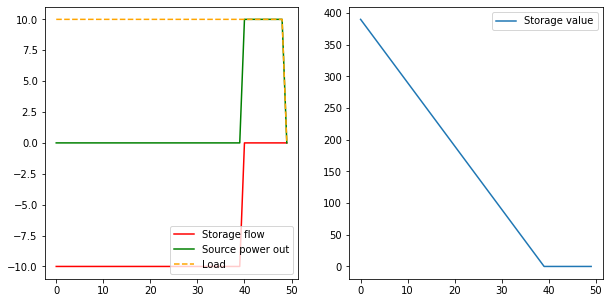

In [5]:
results = model.get_results(as_dataframe=False)

print(f"Total price : {sum(results['expensive_unit']['power_out']*price_ts['value'])*100}.")

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(results["storage"]["flow"], label = "Storage flow", color="r")
plt.plot(results["expensive_unit"]["power_out"], label = "Source power out", color="g")
plt.plot(results["load"]["power_in"], label = "Load", linestyle = "dashed", color="orange")
plt.legend()
plt.subplot(122)
plt.plot(results["storage"]["storage"], label = "Storage value")
plt.legend()
plt.show()